In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
from sklearn.utils import resample
# For modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from tqdm.notebook import tqdm
from matplotlib.colors import ListedColormap
#sns.set_palette('viridis')
pd.options.mode.chained_assignment = None  # Supress warning, default='warn'

# Read Data
In this section we read the data (pickle file) after the preprocessing from the preprocessing notebook/part

In [23]:
df = pd.read_pickle('../data/preprocessed/accepted_df_preprocessed.pkl')
print(f"Shape of df: {df.shape}")
df.head(5)

Shape of df: (1345310, 101)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,3600.0,3600.0,3600.0,36,13.99,123.03,C,C4,10.0,MORTGAGE,...,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,24700.0,24700.0,24700.0,36,11.99,820.28,C,C1,10.0,MORTGAGE,...,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,20000.0,20000.0,20000.0,60,10.78,432.66,B,B4,10.0,MORTGAGE,...,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
4,10400.0,10400.0,10400.0,60,22.45,289.91,F,F1,3.0,MORTGAGE,...,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N
5,11950.0,11950.0,11950.0,36,13.44,405.18,C,C3,4.0,RENT,...,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,N,Cash,N


# TAKE SUBSAMPLE OF DATA FOR COMPUTATION ISSUES (TODO: DELETE THIS LATER)

In [24]:
df = df.sample(frac = 0.1)
print(df.shape)

(134531, 101)


# Model Preprocessing: Encode Features from categorical to numerical
In this section we prepare our data set for modeling through fixing the inbalancement of our data, encoding categorical data, dropping features that are only apriori the application known etc...

## Drop columns for prediction
In this small section we drop features that we do not have prior the lending application. We consulted the data dictionary table (seen [here](https://docs.google.com/spreadsheets/d/13YQDRQYYbr84wy7zQ91yfC8QoEBFPFP0zR5pIDf18rA/edit#gid=629438262)) and analyzed which columns to keep and which to drop. Note that this requires a lot of domain knowledge.

In [25]:
keep_list = ['addr_state', 'annual_inc', 'annual_inc_joint', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']

cols_to_drop = [col for col in df.columns if col not in keep_list]
print(f"Cols to drop: {cols_to_drop}")
df.drop(cols_to_drop, axis=1, inplace=True)
print(f"Shape of df after drop: {df.shape}")

Cols to drop: ['funded_amnt', 'funded_amnt_inv', 'pymnt_plan', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever

In [26]:
# Preview categorical data
print(df.dtypes.value_counts())
# Get categorical columns names
cat_columns = df.select_dtypes(include=['object']).columns.tolist()
# Preview
print(cat_columns)

float64    15
object      9
int32       1
dtype: int64
['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type']


### Deleted irrelevant categorical features
Delete categorical features that are not relevant for the Modelling or contain too many realization so that encoding them would be infeasible.

In [27]:
# Define categorical columns from cat_columns to keep here
CAT_COLS_TO_KEEP = ["term", "home_ownership", "grade", "verification_status", "application_type", "initial_list_status", "purpose"]
CAT_COLS_TO_DROP = [col for col in cat_columns if col not in CAT_COLS_TO_KEEP]

print(f"Categorical Columns to drop: {CAT_COLS_TO_DROP}\n")
print(f"Shape of df before columns drop: {df.shape}")
# Drop irrelevant categorical features
df.drop(CAT_COLS_TO_DROP, axis=1, inplace=True)
print(f"Shape of df after columns drop: {df.shape}")

Categorical Columns to drop: ['sub_grade', 'addr_state']

Shape of df before columns drop: (134531, 25)
Shape of df after columns drop: (134531, 23)


## Preview of the remaining categorical features

In [28]:
print(df.dtypes.value_counts())
df.select_dtypes("object")

float64    15
object      7
int32       1
dtype: int64


,term,grade,home_ownership,verification_status,purpose,initial_list_status,application_type
1817813,36,B,OWN,Not Verified,home_improvement,f,Individual
1743636,60,C,MORTGAGE,Verified,debt_consolidation,w,Individual
1840077,60,E,MORTGAGE,Verified,small_business,f,Individual
2194945,36,B,MORTGAGE,Verified,credit_card,w,Individual
1881636,36,B,MORTGAGE,Not Verified,credit_card,f,Individual
...,...,...,...,...,...,...,...
90364,36,B,RENT,Source Verified,debt_consolidation,f,Individual
826902,36,B,OWN,Not Verified,credit_card,w,Individual
111583,36,C,RENT,Source Verified,debt_consolidation,f,Individual
895246,36,C,MORTGAGE,Verified,debt_consolidation,w,Individual


## Create Dummy Variables

In [29]:
# Binary Encoding
import category_encoders as ce
encoder = ce.BinaryEncoder(cols=CAT_COLS_TO_KEEP)
df_binary = encoder.fit_transform(df)
# check
df_binary.dtypes.value_counts()

int64      18
float64    15
int32       1
dtype: int64

In [30]:
# Convert all values to float
df_binary = df_binary.astype(np.float32)
df_binary.dtypes.value_counts()

float32    34
dtype: int64

## Preview preprocessed dataframe

In [31]:
df_binary.head(10)

,loan_amnt,term_0,term_1,int_rate,installment,grade_0,grade_1,grade_2,emp_length,home_ownership_0,...,pub_rec,revol_bal,revol_util,total_acc,initial_list_status_0,initial_list_status_1,application_type_0,application_type_1,mort_acc,pub_rec_bankruptcies
1817813,8325.0,0.0,1.0,9.71,267.500000,0.0,0.0,1.0,2.0,0.0,...,0.0,10063.0,54.700001,9.0,0.0,1.0,0.0,1.0,0.0,0.0
1743636,35000.0,1.0,0.0,14.99,832.469971,0.0,1.0,0.0,10.0,0.0,...,0.0,38943.0,71.199997,49.0,1.0,0.0,0.0,1.0,6.0,0.0
1840077,35000.0,1.0,0.0,21.49,956.549988,0.0,1.0,1.0,9.0,0.0,...,0.0,16633.0,33.299999,42.0,0.0,1.0,0.0,1.0,7.0,0.0
2194945,7200.0,0.0,1.0,11.49,237.399994,0.0,0.0,1.0,10.0,0.0,...,0.0,12502.0,67.000000,22.0,1.0,0.0,0.0,1.0,6.0,0.0
1881636,7200.0,0.0,1.0,12.12,239.559998,0.0,0.0,1.0,10.0,0.0,...,0.0,10994.0,65.800003,24.0,0.0,1.0,0.0,1.0,2.0,0.0
1231633,6000.0,0.0,1.0,11.67,198.350006,0.0,0.0,1.0,4.0,0.0,...,0.0,3097.0,68.800003,18.0,1.0,0.0,0.0,1.0,1.0,0.0
1175648,15000.0,1.0,0.0,22.15,415.570007,0.0,1.0,1.0,1.0,0.0,...,0.0,6442.0,55.099998,23.0,1.0,0.0,0.0,1.0,2.0,0.0
2048,20000.0,0.0,1.0,5.32,602.299988,1.0,0.0,0.0,0.0,0.0,...,0.0,8152.0,9.600000,19.0,0.0,1.0,0.0,1.0,3.0,0.0
1082525,33100.0,0.0,1.0,15.77,1159.949951,1.0,0.0,1.0,2.0,0.0,...,0.0,8850.0,13.000000,11.0,1.0,0.0,0.0,1.0,0.0,0.0
889394,28000.0,0.0,1.0,15.05,971.320007,0.0,1.0,0.0,2.0,0.0,...,1.0,0.0,0.000000,12.0,1.0,0.0,0.0,1.0,2.0,0.0


## Create Balanced Data Set via Downsampling

0.0    107708
1.0     26823
Name: loan_status, dtype: int64
(134531, 34)


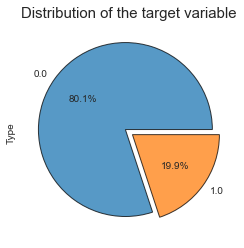

In [32]:
print(df_binary.loan_status.value_counts())
print(df_binary.shape)

plt.title("Distribution of the target variable", size=15)
df_binary.groupby('loan_status').size().plot(kind='pie', y = "loan_status",
                                             label = "Type", autopct='%1.1f%%',
                                             wedgeprops = {"edgecolor": "black", "alpha": 0.75},
                                             explode = [0.05, 0.05])
plt.show()

0.0    34870
1.0    26823
Name: loan_status, dtype: int64


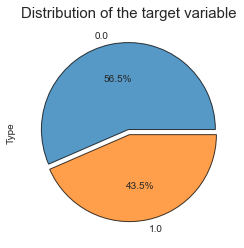

In [33]:
# Downsampling
loan_status_0 = df_binary[df_binary["loan_status"] == 0.0]
loan_status_1  = df_binary[df_binary["loan_status"] == 1.0]

loan_status_0_downsample = resample(loan_status_0,
             replace=True,
             n_samples=round(1.3*len(loan_status_1)),
             random_state=42)

df_binary_downsampled = pd.concat([loan_status_0_downsample, loan_status_1])

print(df_binary_downsampled["loan_status"].value_counts())
# Plot settings
plt.title("Distribution of the target variable", size=15)
df_binary_downsampled.groupby('loan_status').size().plot(kind='pie', y = "loan_status",
                                             label = "Type", autopct='%1.1f%%',
                                             wedgeprops = {"edgecolor": "black", "alpha": 0.75},
                                             explode = [0.03, 0.03])
plt.show()

## Data Imputation
Since we still have some NaNs in our feature, we replace them by taking the median values.

In [34]:
# Fill NaNs with Median
df_binary_downsampled = df_binary_downsampled.fillna(df_binary_downsampled.median())
# Preview
df_binary_downsampled.head(5)

,loan_amnt,term_0,term_1,int_rate,installment,grade_0,grade_1,grade_2,emp_length,home_ownership_0,...,pub_rec,revol_bal,revol_util,total_acc,initial_list_status_0,initial_list_status_1,application_type_0,application_type_1,mort_acc,pub_rec_bankruptcies
2133803,6000.0,0.0,1.0,7.97,187.940002,1.0,0.0,0.0,0.0,0.0,...,0.0,4592.0,20.100000,9.0,1.0,0.0,0.0,1.0,0.0,0.0
1028489,28000.0,0.0,1.0,11.47,922.929993,0.0,0.0,1.0,8.0,0.0,...,1.0,9984.0,45.000000,16.0,1.0,0.0,0.0,1.0,1.0,1.0
1030571,25000.0,0.0,1.0,13.67,850.440002,0.0,1.0,0.0,8.0,0.0,...,0.0,23850.0,69.699997,22.0,1.0,0.0,0.0,1.0,0.0,0.0
1784170,4200.0,0.0,1.0,12.99,141.500000,0.0,0.0,1.0,8.0,0.0,...,0.0,13803.0,67.300003,30.0,0.0,1.0,0.0,1.0,2.0,0.0
1335402,6000.0,0.0,1.0,12.85,201.740005,0.0,0.0,1.0,9.0,0.0,...,0.0,2191.0,6.200000,13.0,0.0,1.0,0.0,1.0,2.0,0.0


## Data Split
In this section we split the data into a training and test set. The corresponding model is then trained on the training set and tested on the test set.

In [35]:
# Fraction of test data
TEST_SIZE = 0.3

X = df_binary_downsampled.drop("loan_status", axis=1)
y = df_binary_downsampled["loan_status"]

# Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42, stratify=y)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (43185, 33)
Shape of X_test: (18508, 33)
Shape of y_train: (43185,)
Shape of y_test: (18508,)


## Scaling
We scale the data with the MinMaxScaler to a range of $[0, 1]$

In [36]:
# Init object
scaler = MinMaxScaler()
# Scale X_train
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)
# Scale X_test
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled)

# Preview X_train_scaled
X_train_scaled.head(10)

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.358974,0.0,1.0,0.139798,0.267976,1.0,0.0,0.0,0.2,0.0,...,0.000000,0.019716,0.652609,0.126126,1.0,0.0,0.0,1.0,0.000000,0.0
1,0.538462,0.0,1.0,0.111760,0.395039,0.0,0.0,1.0,0.1,0.0,...,0.000000,0.030615,0.393138,0.441441,1.0,0.0,0.0,1.0,0.000000,0.0
2,0.615385,1.0,0.0,0.496495,0.362187,1.0,0.0,1.0,1.0,0.0,...,0.000000,0.017291,0.472480,0.189189,1.0,0.0,0.0,1.0,0.000000,0.0
3,0.743590,0.0,1.0,0.389408,0.603897,0.0,1.0,0.0,0.5,0.0,...,0.000000,0.030721,0.488921,0.162162,0.0,1.0,0.0,1.0,0.000000,0.0
4,0.487180,0.0,1.0,0.100467,0.356311,1.0,0.0,0.0,1.0,0.0,...,0.000000,0.038678,0.433167,0.387387,0.0,1.0,0.0,1.0,0.269231,0.0
5,0.102564,0.0,1.0,0.401480,0.089765,1.0,0.0,1.0,0.1,0.0,...,0.000000,0.005769,0.522516,0.027027,0.0,1.0,0.0,1.0,0.038462,0.0
6,0.487180,1.0,0.0,0.488707,0.285741,1.0,0.0,1.0,1.0,0.0,...,0.000000,0.034242,0.355969,0.351351,0.0,1.0,0.0,1.0,0.038462,0.0
7,0.487180,0.0,1.0,0.503894,0.415334,1.0,0.0,1.0,0.2,0.0,...,0.086957,0.017505,0.637598,0.099099,1.0,0.0,0.0,1.0,0.000000,0.0
8,0.115385,0.0,1.0,0.274143,0.094938,0.0,0.0,1.0,0.2,0.0,...,0.000000,0.008410,0.215154,0.090090,0.0,1.0,0.0,1.0,0.000000,0.0
9,0.051282,0.0,1.0,0.401090,0.048412,1.0,0.0,1.0,0.0,0.0,...,0.000000,0.011145,0.375983,0.054054,0.0,1.0,0.0,1.0,0.000000,0.0


---
# Task 3: Logistic Regression In Sample
Use logistic regression (in-sample) for default prediction. Interpret your results for logistic regression

In [37]:
# Fit Model
lr = LogisticRegression(max_iter=1000, fit_intercept=True)
lr.fit(X_train_scaled, y_train)

# Predict in sample, i.e. predict on seen data (trainings data) instead of unseen data (test)
y_pred = lr.predict(X_train_scaled)

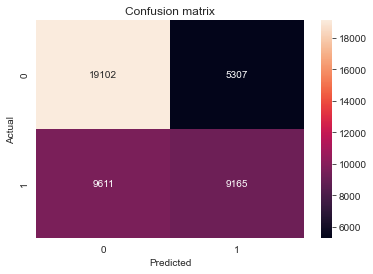

              precision    recall  f1-score   support

         0.0       0.67      0.78      0.72     24409
         1.0       0.63      0.49      0.55     18776

    accuracy                           0.65     43185
   macro avg       0.65      0.64      0.64     43185
weighted avg       0.65      0.65      0.65     43185



In [38]:
# Plot Confusion matrics
cm = confusion_matrix(y_true=y_train, y_pred=y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot classification report
print(classification_report(y_true=y_train, y_pred=y_pred))
#print(precision_recall_fscore_support(y_true=y_train, y_pred=y_pred, average="micro"))
#print(round(accuracy_score(y_true=y_train, y_pred=y_pred), 4))

## Interpretation:
TBD

---
# Task 4: Compare different classification models
Comparing
* logistic regression,
* classification tree,
* random forest,
* bagging,
* support vector machine (with two kernel functions),
* and neural network

for default prediction based on the out-of-sample performance measures (at least three different measures).

In [39]:
%%time
models = []

models.append(("LogisticRegression",LogisticRegression(fit_intercept=True, max_iter=1000, solver="saga")))
models.append(("DecisionTree",DecisionTreeClassifier()))
models.append(("RandomForest",RandomForestClassifier()))
models.append(("BaggingCLF",BaggingClassifier()))
models.append(("SVC_rbf",SVC(kernel='rbf', max_iter=500)))
models.append(("SVC_poly",SVC(kernel="poly", max_iter=500)))
models.append(("NeuronalNetwork", MLPClassifier(alpha=1, max_iter=1000)))

results = []
names = []
# Define scoring metrices for CV
scoring = ["accuracy", "precision_micro", "recall_micro", "f1_micro"]
for name, model in tqdm(models):
    result = cross_validate(model, X_train_scaled, y_train,  cv=3, n_jobs=-1, scoring=scoring)
    names.append(name)
    results.append(result)

  0%|          | 0/7 [00:00<?, ?it/s]

CPU times: total: 266 ms
Wall time: 36.5 s


In [40]:
# Get name of metrices (will be column in result_df)
metrices = list(results[0].keys())
# Create empty dataframe
results_df = pd.DataFrame(index=names, columns=metrices, dtype="float32")

# File dataframe by iterating over all results and taking the mean value
for i, name in enumerate(models):
    mean_of_metrices = []
    for key in results[i].keys():
        mean_of_metrices.append(results[i].get(key).mean())
    results_df.iloc[i] = mean_of_metrices

# Drop scoring_time column as it is not of interest
results_df.drop("score_time", axis=1, inplace=True)
# Round to 4 decimal places
results_df = results_df.round(decimals=4)
# Sort descending of f1 score
results_df = results_df.sort_values(by="test_f1_micro", ascending=False)
# Preview
results_df

,fit_time,test_accuracy,test_precision_micro,test_recall_micro,test_f1_micro
RandomForest,5.1258,0.6716,0.6716,0.6716,0.6716
LogisticRegression,1.1458,0.6532,0.6532,0.6532,0.6532
NeuronalNetwork,10.7023,0.6476,0.6476,0.6476,0.6476
BaggingCLF,2.4225,0.6384,0.6384,0.6384,0.6384
DecisionTree,0.4082,0.6016,0.6016,0.6016,0.6016
SVC_rbf,2.4349,0.5574,0.5574,0.5574,0.5574
SVC_poly,1.7856,0.4409,0.4409,0.4409,0.4409


## Results:
We can see that a RandomForest Model performs the best according to the f1 score, which is the harmonic mean between recall and precision. Also LogisticRegression, as a very good interpretable model, performs pretty well and is ranked 2nd. SVC, on the other hands, perform very poorly.

---
# Task 5: Use LASSO for variable selection and explain results

In [41]:
#TBD

In [42]:
#PUFFER

# Task 6: Which model do you suggest to the peer-to-peer company? Why?
We rate each model based on the following four criterias learned on the lecture:
- Interpretability
- Robustness
- Speed
- Scalability
TODO